In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.utils import from_networkx
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# 加载数据对象
data = torch.load('data.pt')

In [3]:
best_params = {'lr': 0.005,
 'weight_decay': 0.001,
 'hidden1': 128,
 'hidden2': 64,
 'dropout': 0.3,
 'num_epochs': 200}

In [4]:
import torch
from torch_geometric.nn import GATv2Conv
# 定义GATv2模型
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.bn1 = torch.nn.BatchNorm1d(hidden1)  # Batch normalization
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.bn2 = torch.nn.BatchNorm1d(hidden2)  # Batch normalization
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        conv1_out = x  # 保存第一层卷积的输出
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        conv2_out = x  # 保存第二层卷积的输出
        x = self.fc1(x)
        return conv1_out, conv2_out, x
# 假设 'data' 是一个预定义的 PyG 数据对象

# 包装模型，只返回最终的输出
class WrappedModel(torch.nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, x, edge_index):
        _, _, out = self.model(x, edge_index)
        return out

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    _, _, out = model(data.x, data.edge_index)  # Unpack the tuple and use only the final output
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()
    
model = GATv2(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)

# 方法1：加载整个模型
loaded_model = torch.load('good_explanation.pth')
wrapped_model = WrappedModel(loaded_model)
wrapped_model.eval()

WrappedModel(
  (model): GATv2(
    (conv1): GATv2Conv(64, 128, heads=1)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GATv2Conv(128, 64, heads=1)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=64, out_features=1, bias=True)
  )
)

Generated explanations in ['edge_mask', 'node_mask']


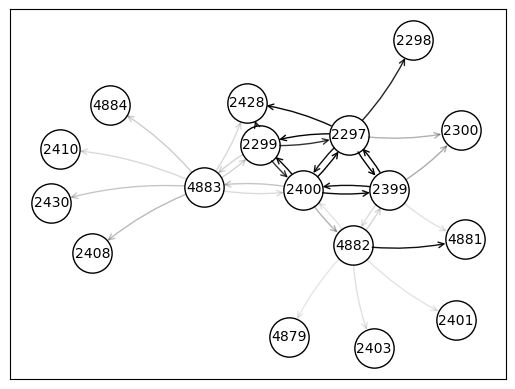

In [20]:
from torch_geometric.explain import Explainer, GNNExplainer
from tqdm import tqdm
for explanation_type in ['phenomenon']:
    explainer = Explainer(
        model=wrapped_model,
        algorithm=GNNExplainer(epochs=200),
        explanation_type=explanation_type,
        node_mask_type='object',
        edge_mask_type='object',
        model_config=dict(
            mode='regression',
            task_level='node',
            return_type='raw',
        ),
        # threshold_config=dict(threshold_type='hard', value=0.5) 
    )

# 选择一个节点进行解释（例如，节点0）
node_idx = 2400
explanation = explainer(data.x, data.edge_index, index=node_idx, target = data.y,)

# 输出解释结果
print(f'Generated explanations in {explanation.available_explanations}')

# 可视化特征重要性
# path = 'feature_importance.png'
# explanation.visualize_feature_importance(path, top_k=10)
# print(f"Feature importance plot has been saved to '{path}'")

# # 可视化子图
# path = 'subgraph.pdf'
# explanation.visualize_graph(path)
# print(f"Subgraph visualization plot has been saved to '{path}'")

# 获取子图节点索引
edge_mask = explanation.edge_mask > 0  # 使用掩码阈值
edge_index = data.edge_index[:, edge_mask]
node_indices = edge_index.unique().tolist()

explanation.visualize_graph()

Node indices: [2297 2298 2299 2300 2399 2400 2401 2403 2408 2410 2428 2430 4879 4881
 4882 4883 4884]
Edge indices: [13657 13659 13661 13665 13670 13671 13673 13675 13677 14262 14264 14265
 14267 14268 14269 14270 14271 14272 14282 14311 14320 14425 14427 14428
 14440 28782 28791 28793 28794 28795 28800 28801 28810]
Node positions: {2297: (505941.7331955598, 181892.04119138524), 2298: (506756.8970826841, 181940.08872005309), 2299: (505684.2589872301, 181275.10759412622), 2300: (506321.46180580085, 182703.22120288268), 2399: (505565.0415017709, 182174.29292400193), 2400: (505118.40252117434, 181605.97578744777), 2401: (504845.4509465851, 183309.885121708), 2403: (505304.4596527307, 183493.73382661198), 2408: (506307.25082135113, 179844.83052022415), 2410: (505657.03735900036, 179853.52398865696), 2428: (506276.92598007614, 181254.18233749812), 2430: (506325.4961695961, 180803.05872037122), 4879: (505657.78472383635, 183585.49184193474), 4881: (505616.88356100285, 182880.99199825217), 48

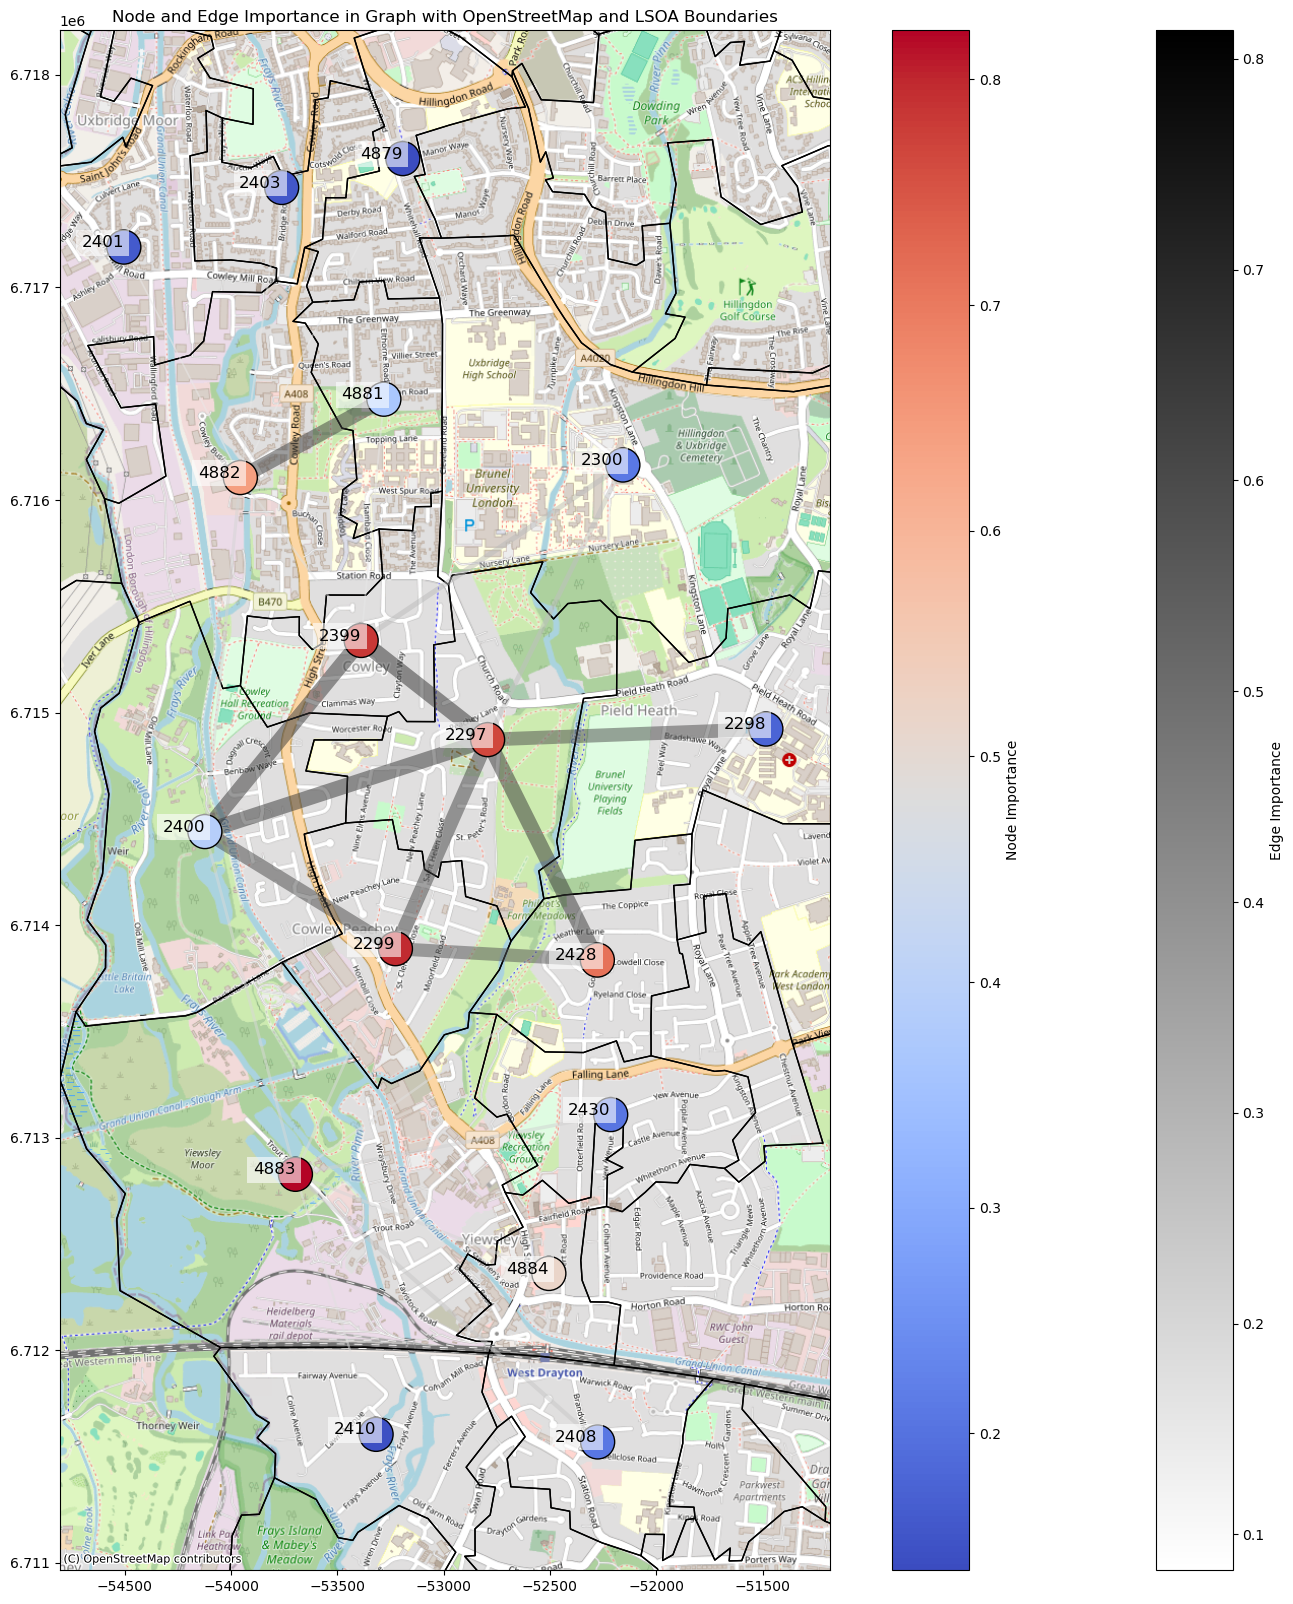

In [21]:
# 获取解释子图中的节点
node_indices = np.where(explanation.node_mask > 0)[0]
edge_indices = np.where(explanation.edge_mask > 0)[0]

# 获取节点的位置数据
node_positions = data.pos.numpy()

# 创建无向图
G = nx.Graph()

# 获取节点的重要性值
node_mask_values = {idx: explanation.node_mask[idx].item() for idx in node_indices}

# 添加解释子图中的节点和节点的重要性值作为属性
for idx in node_indices:
    value = explanation.node_mask[idx].item()
    lat, lon = node_positions[idx]
    G.add_node(int(idx), importance=value, pos=(lon, lat))

# 合成无向边并计算边的重要性
edge_importance = {}
for i in edge_indices:
    mask_value = explanation.edge_mask[i].item()
    source, target = data.edge_index[:, i]
    if source.item() in node_indices and target.item() in node_indices:  # 仅添加解释子图中的边
        if source.item() > target.item():  # 确保无向边的一致性
            source, target = target, source
        if (source.item(), target.item()) in edge_importance:
            edge_importance[(source.item(), target.item())].append(mask_value)
        else:
            edge_importance[(source.item(), target.item())] = [mask_value]

# 输出调试信息
print("Node indices:", node_indices)
print("Edge indices:", edge_indices)
print("Node positions:", {idx: (node_positions[idx][0], node_positions[idx][1]) for idx in node_indices})
print("Edge importance:", edge_importance)

# 计算每条无向边的重要性，对于只有一条有向边的情况直接使用该重要性值
edge_importance = {
    edge: np.mean(values) if len(values) > 1 else values[0] for edge, values in edge_importance.items()
}

# 添加边和边的重要性值作为属性
for (source, target), importance in edge_importance.items():
    G.add_edge(source, target, importance=importance)

# 获取节点位置
pos = nx.get_node_attributes(G, 'pos')

# 将节点位置转换为GeoDataFrame
geometry = [Point(lon, lat) for lat, lon in pos.values()]
node_importance = [G.nodes[node]['importance'] for node in G.nodes]
gdf = gpd.GeoDataFrame(list(pos.keys()), geometry=geometry, columns=['node'])
gdf['importance'] = node_importance

# 设置原始坐标系为EPSG:27700（英国国家格网）
gdf.set_crs(epsg=27700, inplace=True)
# 转换为WGS84坐标系（EPSG:4326）
gdf = gdf.to_crs(epsg=4326)
# 转换为墨卡托投影以匹配OpenStreetMap
gdf = gdf.to_crs(epsg=3857)

# 调试信息：检查转换后的坐标和边界框值
print("Converted coordinates:\n", gdf)
bounds = gdf.total_bounds  # 获取GeoDataFrame的边界框 [minx, miny, maxx, maxy]
print("Bounds:", bounds)

# 绘制图形
fig, ax = plt.subplots(figsize=(20, 20))

# 设置地图范围
if np.isfinite(bounds).all():
    x_buffer = (bounds[2] - bounds[0]) * 0.1
    y_buffer = (bounds[3] - bounds[1]) * 0.1
    ax.set_xlim([bounds[0] - x_buffer, bounds[2] + x_buffer])
    ax.set_ylim([bounds[1] - y_buffer, bounds[3] + y_buffer])
else:
    print("Invalid bounds detected, skipping axis limits setting")

# 添加OpenStreetMap底图
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# 绘制LSOA边界
London_lsoas_2021.boundary.plot(ax=ax, linewidth=1, edgecolor='black', zorder=2)

# 绘制GeoDataFrame并使用importance列作为颜色
gdf.plot(ax=ax, column='importance', cmap=plt.cm.coolwarm, markersize=600, edgecolor='black', zorder=5)

# 确保有边被添加到图中
if len(G.edges) > 0:
    # 绘制边，颜色和粗细根据重要性值进行调整
    for (source, target), importance in edge_importance.items():
        source_pos = gdf.loc[gdf['node'] == source, 'geometry'].values[0]
        target_pos = gdf.loc[gdf['node'] == target, 'geometry'].values[0]
        ax.plot([source_pos.x, target_pos.x], [source_pos.y, target_pos.y], 
                color=plt.cm.binary(importance), linewidth=14*importance, alpha=0.5, zorder=3)

    # 添加颜色条以显示边的重要性
    sm_edges = plt.cm.ScalarMappable(cmap=plt.cm.binary, norm=plt.Normalize(vmin=min(edge_importance.values()), vmax=max(edge_importance.values())))
    sm_edges._A = []
    plt.colorbar(sm_edges, ax=ax, label='Edge Importance')

# 添加节点的重要性颜色条
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(node_importance), vmax=max(node_importance)))
sm._A = []
plt.colorbar(sm, ax=ax, label='Node Importance')

# 添加节点标签
for node, (lat, lon) in pos.items():
    point = gpd.GeoSeries([Point(lon, lat)], crs="EPSG:27700").to_crs("EPSG:3857").geometry[0]
    ax.text(point.x, point.y, str(node), fontsize=12, ha='right', zorder=10, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.title("Node and Edge Importance in Graph with OpenStreetMap and LSOA Boundaries")
plt.show()

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

# 读取LSOA的shapefile并转换坐标系
fp = 'LSOA_(Dec_2021)_Boundaries_Generalised_Clipped_EW_(BGC).shp'
London_lsoas_2021 = gpd.read_file(fp).rename(columns={'LSOA21CD':'geography code'})
London_lsoas_2021 = London_lsoas_2021[London_lsoas_2021["geography code"].str.startswith("E")]

# 设置原始坐标系为EPSG:27700（英国国家格网）
London_lsoas_2021.set_crs(epsg=27700, inplace=True)
# 转换为WGS84坐标系（EPSG:4326）
London_lsoas_2021 = London_lsoas_2021.to_crs(epsg=4326)
# 转换为墨卡托投影以匹配OpenStreetMap
London_lsoas_2021 = London_lsoas_2021.to_crs(epsg=3857)